<div align="center">

# Projeto 1 - Aprendizado de Máquina (2025)  
## **Professor:** Francisco A. Rodrigues  
## **Alunos:**  
Gustavo Gabriel Ribeiro - 13672683  
Letícia - 

</div>


# Imports

In [16]:
import time

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from mlforecast.feature_engineering import transform_exog
from mlforecast.lag_transforms import (
    ExpandingMax,
    ExpandingMean,
    ExpandingMin,
    ExpandingStd,
    RollingMax,
    RollingMean,
    RollingMin,
    RollingStd,
)
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import (
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import (
    mean_absolute_error,
    r2_score,
    root_mean_squared_error,
    root_mean_squared_log_error,
)
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Configs

In [17]:
pd.set_option("display.max_columns", None)
optuna.logging.set_verbosity(optuna.logging.DEBUG)

# Paths

In [6]:
base_folder = "../data/Ecuador Forecasting/"
competition_data_folder = "competition_data/"
save_folder = "saved_datasets/"
submissions_folder = "submission_files/"

In [7]:
df_train_filename = "train.csv"
df_test_filename = "test.csv"
df_stores_filename = "stores.csv"
df_oil_filename = "oil.csv"
df_holidays_events_filename = "holidays_events.csv"
df_transactions_filename = "transactions.csv"

# Development

## Reading Datasets

In [5]:
df_train = pd.read_csv(base_folder + competition_data_folder + df_train_filename)
df_test = pd.read_csv(base_folder + competition_data_folder + df_test_filename)
df_stores = pd.read_csv(base_folder + competition_data_folder + df_stores_filename)
df_oil = pd.read_csv(base_folder + competition_data_folder + df_oil_filename)
df_holidays_events = pd.read_csv(
    base_folder + competition_data_folder + df_holidays_events_filename
)
df_transactions = pd.read_csv(base_folder + competition_data_folder + df_transactions_filename)

In [53]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [54]:
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [55]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [56]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [57]:
df_holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [58]:
df_transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


## Exploratory Data Analysis

In [59]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(df_train, title='Pandas Profiling Report', explorative=True)
# profile.to_notebook_iframe()

## Preprocessing

> Nessa etapas, faremos tratamentos individuais, quando necessário, a cada um dos datasets que componherão o dataset final que será usado para o treinamento

In [60]:
# Transformando todas as colunas 'date' em datetime para facilitar o trabalho com datas.
df_train["date"] = pd.to_datetime(df_train["date"])
df_test["date"] = pd.to_datetime(df_test["date"])
df_oil["date"] = pd.to_datetime(df_oil["date"])
df_holidays_events["date"] = pd.to_datetime(df_holidays_events["date"])
df_transactions["date"] = pd.to_datetime(df_transactions["date"])

# Pegando as datas mínima e máxima do conjunto de treino e de teste
train_min_date = df_train["date"].min()
train_max_date = df_train["date"].max()
test_min_date = df_test["date"].min()
test_max_date = df_test["date"].max()

# Exibindo o intervalo de datas dos datasets de treino e teste
print("Período do treino:", train_min_date, "até", train_max_date, "Quantidade de dias:", (train_max_date - train_min_date).days)
print("Período do teste:", test_min_date, "até", test_max_date, "Quantidade de dias:", (test_max_date - test_min_date).days)

Período do treino: 2013-01-01 00:00:00 até 2017-08-15 00:00:00 Quantidade de dias: 1687
Período do teste: 2017-08-16 00:00:00 até 2017-08-31 00:00:00 Quantidade de dias: 15


In [61]:
# Juntando os dados de treino e teste em um único DataFrame
df = pd.concat([df_train, df_test], axis=0, ignore_index=True)

# Criando um identificador único para cada combinação de loja e família de produto
df["unique_id"] = df.groupby(["store_nbr", "family"]).ngroup()

### Train-Test Dataset

In [62]:
# Não há valores nulos no dataset, exceto pela parte de treinamento, em que não temos o target
df.isna().sum()

id                 0
date               0
store_nbr          0
family             0
sales          28512
onpromotion        0
unique_id          0
dtype: int64

In [63]:
# Criando uma cópia do Dataset para processamento
df_joined = df.copy()

### Stores Dataset

In [64]:
# Não há valores nulos
df_stores.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [65]:
# Unimos esse dataset a nosso dataset principal
df_joined = df_joined.merge(df_stores, on="store_nbr", how="left")

### Oil Dataset

In [66]:
# Há valores nulos
df_oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [67]:
# Investigando quando os valores nulos ocorrem, obtemos a seguinte informação
df_oil["weekday"] = df_oil["date"].dt.day_name()
df_oil.groupby("weekday")["dcoilwtico"].apply(lambda x: x.isna().sum()).reset_index()

,weekday,dcoilwtico
0,Friday,9
1,Monday,23
2,Thursday,7
3,Tuesday,2
4,Wednesday,2


In [68]:
# Preenchendo os valores ausentes da coluna 'dcoilwtico' com o valor anterior presente (forward fill)
df_oil["dcoilwtico"] = df_oil["dcoilwtico"].ffill()

In [69]:
# Checando que os valores nulos foram preenchidos
df_oil.groupby("weekday")["dcoilwtico"].apply(lambda x: x.isna().sum()).reset_index()

,weekday,dcoilwtico
0,Friday,0
1,Monday,0
2,Thursday,0
3,Tuesday,1
4,Wednesday,0


In [70]:
# Unimos esse dataset a nosso dataset principal
df_joined = df_joined.merge(df_oil[["date", "dcoilwtico"]], on="date", how="left")

### Holidays Dataset

In [71]:
# Não há valores nulos
df_holidays_events.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [72]:
# Coletando os nomes únicos de regiões para cada tipo de feriado: Nacional, Regional e Local
national_locale_name = sorted(
    df_holidays_events[df_holidays_events["locale"] == "National"]["locale_name"].unique().tolist()
)
regional_locale_name = sorted(
    df_holidays_events[df_holidays_events["locale"] == "Regional"]["locale_name"].unique().tolist()
)
local_locale_name = sorted(
    df_holidays_events[df_holidays_events["locale"] == "Local"]["locale_name"].unique().tolist()
)

# Mostrando os nomes associados a cada tipo de feriado
print("Nomes de localidades com feriado nacional:\n", national_locale_name)
print("Nomes de localidades com feriado regional:\n", regional_locale_name)
print("Nomes de localidades com feriado local:\n", local_locale_name)

Nomes de localidades com feriado nacional:
 ['Ecuador']
Nomes de localidades com feriado regional:
 ['Cotopaxi', 'Imbabura', 'Santa Elena', 'Santo Domingo de los Tsachilas']
Nomes de localidades com feriado local:
 ['Ambato', 'Cayambe', 'Cuenca', 'El Carmen', 'Esmeraldas', 'Guaranda', 'Guayaquil', 'Ibarra', 'Latacunga', 'Libertad', 'Loja', 'Machala', 'Manta', 'Puyo', 'Quevedo', 'Quito', 'Riobamba', 'Salinas', 'Santo Domingo']


In [73]:
# Selecionando as colunas categóricas e exibindo os valores únicos ordenados para cada uma delas
categorical_cols = df_holidays_events.select_dtypes(include=["object", "category"]).columns
for col in categorical_cols:
    print(f"Valores únicos para a coluna {col}:\n", sorted(df_holidays_events[col].unique()))

Valores únicos para a coluna type:
 ['Additional', 'Bridge', 'Event', 'Holiday', 'Transfer', 'Work Day']
Valores únicos para a coluna locale:
 ['Local', 'National', 'Regional']
Valores únicos para a coluna locale_name:
 ['Ambato', 'Cayambe', 'Cotopaxi', 'Cuenca', 'Ecuador', 'El Carmen', 'Esmeraldas', 'Guaranda', 'Guayaquil', 'Ibarra', 'Imbabura', 'Latacunga', 'Libertad', 'Loja', 'Machala', 'Manta', 'Puyo', 'Quevedo', 'Quito', 'Riobamba', 'Salinas', 'Santa Elena', 'Santo Domingo', 'Santo Domingo de los Tsachilas']
Valores únicos para a coluna description:
 ['Batalla de Pichincha', 'Black Friday', 'Cantonizacion de Cayambe', 'Cantonizacion de El Carmen', 'Cantonizacion de Guaranda', 'Cantonizacion de Latacunga', 'Cantonizacion de Libertad', 'Cantonizacion de Quevedo', 'Cantonizacion de Riobamba', 'Cantonizacion de Salinas', 'Cantonizacion del Puyo', 'Carnaval', 'Cyber Monday', 'Dia de Difuntos', 'Dia de la Madre', 'Dia de la Madre-1', 'Dia del Trabajo', 'Fundacion de Ambato', 'Fundacion 

In [74]:
# TODO Remover

# def process_holiday(s):
#     if "futbol" in s:
#         return "futbol"
#     to_remove = list(set(df_stores.city.str.lower()) | set(df_stores.state.str.lower()))
#     for w in to_remove:
#         s = s.replace(w, "")
#     return s


# df_holidays_events.description = (
#     df_holidays_events.apply(
#         lambda x: x.description.lower().replace(x.locale_name.lower(), ""),
#         axis=1,
#     )
#     .apply(process_holiday)
#     .replace(
#         r"[+-]\d+|\b(de|del|traslado|recupero|puente|-)\b",
#         "",
#         regex=True,
#     )
#     .replace(
#         r"\s+|-",
#         " ",
#         regex=True,
#     )
#     .str.strip()
# )

In [75]:
# df_holidays_events.description = (
#     df_holidays_events.apply(
#         lambda x: x.description.lower().replace(x.locale_name.lower(), ""),
#         axis=1,
#     )
#     .apply(process_holiday)
#     .replace(
#         r"[+-]\d+|\b(de|del|traslado|recupero|puente|-)\b",
#         "",
#         regex=True,
#     )
#     .replace(
#         r"\s+|-",
#         " ",
#         regex=True,
#     )
#     .str.strip()
# )

In [76]:
df_holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [77]:
# Unimos esse dataset a nosso dataset principal
df_joined = df_joined.merge(df_holidays_events, on="date", how="left", suffixes=("", "_holiday"))

# Criamos condições específicas para classificar o tipo de feriado, dependendo se é nacional, regional ou local, com base na comparação da localidade e nome da localidade.
# O np.select é utilizado para aplicar essas condições e atribuir o tipo de feriado apropriado à nova coluna 'type_holiday'.
cond_national = df_joined["locale"] == "National"
cond_regional = (df_joined["locale"] == "Regional") & (
    df_joined["locale_name"] == df_joined["state"]
)
cond_local = (df_joined["locale"] == "Local") & (df_joined["locale_name"] == df_joined["city"])

df_joined["type_holiday"] = np.select(
    [cond_national, cond_regional, cond_local],
    [
        df_joined["type_holiday"],
        df_joined["type_holiday"],
        df_joined["type_holiday"],
    ],
    default=None,
)

# Após isso, removemos duplicatas com base no id (datas que em uma mesma localidade houve mais de um feriado), mantemos apenas o primeiro que aparece.
df_joined = df_joined.drop_duplicates(subset="id", keep="first").reset_index(drop=True)


### Transactions Dataset

In [78]:
# Não há valores nulos
df_transactions.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [79]:
# Unimos esse dataset a nosso dataset principal
df_joined = df_joined.merge(df_transactions, on=["date", "store_nbr"], how="left")

## Feature Engineering

> Com o dataset resultante da etapa anterior, vamos agora realizar o feature engineering e aplicar quaisquer tratamentos necessários para preparar os dados para o modelo.

### Date Features

In [80]:
# Criamos várias novas features baseadas em informações temporais da coluna 'date'. 
# Essas features são importantes pois permitem que o modelo capture padrões sazonais, cíclicos e temporais no comportamento dos dados.

# Exemplo de features criadas:
# - 'year', 'month', 'day': permitem que o modelo compreenda o comportamento por ano, mês e dia.
# - 'day_of_week', 'day_name': ajudam a identificar padrões de dias específicos (por exemplo, finais de semana).
# - 'is_weekend', 'is_month_start', 'is_month_end': indicam características específicas do calendário, úteis para capturar sazonalidades.


df_joined["year"] = df_joined["date"].dt.year
df_joined["month"] = df_joined["date"].dt.month
df_joined["day"] = df_joined["date"].dt.day
df_joined["day_of_week"] = df_joined["date"].dt.weekday
df_joined["day_name"] = df_joined["date"].dt.day_name()
df_joined["month_name"] = df_joined["date"].dt.month_name()
df_joined["week"] = df_joined["date"].dt.isocalendar().week
df_joined["quarter"] = df_joined["date"].dt.quarter
df_joined["day_of_year"] = df_joined["date"].dt.dayofyear
df_joined["is_weekend"] = df_joined["day_of_week"].isin([5, 6]).astype(int)
df_joined["is_month_start"] = df_joined["date"].dt.is_month_start.astype(int)
df_joined["is_month_end"] = df_joined["date"].dt.is_month_end.astype(int)
df_joined["is_quarter_start"] = df_joined["date"].dt.is_quarter_start.astype(int)
df_joined["is_quarter_end"] = df_joined["date"].dt.is_quarter_end.astype(int)
df_joined["is_year_start"] = df_joined["date"].dt.is_year_start.astype(int)
df_joined["is_year_end"] = df_joined["date"].dt.is_year_end.astype(int)

### Target Features

In [ ]:
# Criamos features relacionadas ao target (vendas), como:
# - Lags (lag_1, lag_2, etc.)
# - Estatísticas de vendas (média, máximo, mínimo, desvio padrão) para diferentes janelas temporais (última semana, 2 semanas, mês).
# Essas features são importantes para capturar dependências temporais e padrões sazonais nas vendas.
# Para evitar "target leakage", iniciamos a criação dos lags a partir do lag 16, garantindo que não utilizemos dados futuros do conjunto de teste durante o treinamento.

df_target = df_joined[["date", "unique_id", "sales"]]
df_target_features = transform_exog(
    df_target,
    time_col="date",
    lags=[16, 17, 18, 19, 20, 21, 22],
    lag_transforms={
        16: [
            ExpandingMax(),
            ExpandingMean(),
            ExpandingMin(),
            ExpandingStd(),
            RollingMax(7),
            RollingMin(7),
            RollingMean(7),
            RollingStd(7),
            RollingMax(14),
            RollingMin(14),
            RollingMean(14),
            RollingStd(14),
            RollingMean(28),
            RollingMax(28),
            RollingMin(28),
            RollingStd(28),
        ]
    },
    num_threads=16,
).drop("sales", axis=1)
df_joined = df_joined.merge(df_target_features, on=["date", "unique_id"], how="left")

### Holiday Features

In [82]:
# De acordo com a especificação da competição no Kaggle, dias em que o feriado foi transferido para outra data devem ser tratados como dias comuns.
# Portanto, removemos os feriados transferidos, substituindo o tipo de feriado por None nesses casos.
df_joined["type_holiday"] = np.where(
    (df_joined["type_holiday"] == "Holiday") & (df_joined["transferred"]),
    None,
    df_joined["type_holiday"],
)

In [83]:
# Por sua vez, adicionamos os dias para os quais foram transferidos como feriados, substituindo o tipo "Transfer" por "Holiday" na coluna 'type_holiday'.
df_joined["type_holiday"] = np.where(
    df_joined["type_holiday"] == "Transfer",
    "Holiday",
    df_joined["type_holiday"],
)

In [84]:
# Dias que não possuem um tipo de feriado são dias sem feriados ("No Holiday")
df_joined["type_holiday"] = df_joined["type_holiday"].fillna("No Holiday")

In [85]:
# TODO Remover Dummie de feriados
# holiday = df_holidays_events[df_holidays_events.transferred.eq(False)]
# national_holidays = holiday[holiday.locale.eq("National")]
# national_holidays = national_holidays[["date", "description"]].reset_index(drop=True)
# national_holidays = national_holidays[~national_holidays.duplicated()]
# national_holidays = pd.get_dummies(national_holidays, columns=["description"], prefix="nat")
# national_holidays = national_holidays.groupby("date").sum().reset_index()
# national_holidays = national_holidays.rename(
#     columns={"nat_primer grito independencia": "nat_primer grito"}
# )
# selected_holidays = [
#     "nat_terremoto",
#     "nat_navidad",
#     "nat_dia la madre",
#     "nat_dia trabajo",
#     "nat_primer dia ano",
#     "nat_futbol",
#     "nat_dia difuntos",
# ]
# keep_national_holidays = national_holidays[["date", *selected_holidays]]
# df_joined = df_joined.merge(keep_national_holidays, on="date", how="left")
# df_joined[selected_holidays] = df_joined[selected_holidays].fillna(0)

In [86]:
# TODO Testar com granularidade alta nos tipos de feriados, ou so feriado ou não
# def map_holiday(value):
#     if value in ["Work Day", "No Holiday"]:
#         return "No Holiday"
#     else:
#         return "Holiday"


# df_joined["type_holiday"] = df_joined["type_holiday"].apply(map_holiday)

df_joined = df_joined.drop(["locale", "locale_name", "description", "transferred"], axis=1)

### Oil Features

In [87]:
# Após o merge com o dataset final, novos valores nulos aparecem, especialmente nos finais de semana. 
# Isso pode ser devido à interrupção das flutuações do preço do petróleo no mercado nos fins de semana.
df_joined.groupby("day_name")["dcoilwtico"].apply(lambda x: x.isna().sum()).reset_index()

,day_name,dcoilwtico
0,Friday,0
1,Monday,0
2,Saturday,433026
3,Sunday,431244
4,Thursday,0
5,Tuesday,1782
6,Wednesday,0


In [88]:
# Realizamos o preenchimento dos valores nulos no preço do petróleo ('dcoilwtico') por meio de forward fill (ffill) e backward fill (bfill).
# Isso garante que os valores ausentes sejam preenchidos com os valores disponíveis nas observações anteriores (ffill) ou posteriores (bfill),.
df_joined["dcoilwtico"] = df_joined.groupby(["unique_id"])["dcoilwtico"].ffill().bfill()

In [89]:
# Não há mais valores nulos
df_joined.groupby("day_name")["dcoilwtico"].apply(lambda x: x.isna().sum()).reset_index()

,day_name,dcoilwtico
0,Friday,0
1,Monday,0
2,Saturday,0
3,Sunday,0
4,Thursday,0
5,Tuesday,0
6,Wednesday,0


In [ ]:
# De forma análoga ao que fizemos para as vendas, criamos features temporais para o preço do petróleo ('dcoilwtico'),
# como lags (1, 2, 3, 4, 5, 6, 7, 14, 28 dias) e transformações rolling (máximo, mínimo, média, desvio padrão) para diferentes janelas temporais (7, 14, 28 dias).
# Essas features ajudam a capturar a dinâmica temporal do preço do petróleo, que pode impactar as vendas e outras variáveis no modelo.
df_oil = df_joined[["date", "unique_id", "dcoilwtico"]]
df_oil_features = transform_exog(
    df_oil,
    time_col="date",
    lags=[1, 2, 3, 4, 5, 6, 7],
    lag_transforms={
        1: [
            ExpandingMax(),
            ExpandingMean(),
            ExpandingMin(),
            ExpandingStd(),
            RollingMax(7),
            RollingMin(7),
            RollingMean(7),
            RollingStd(7),
            RollingMax(14),
            RollingMin(14),
            RollingMean(14),
            RollingStd(14),
            RollingMean(28),
            RollingMax(28),
            RollingMin(28),
            RollingStd(28),
        ]
    },
    num_threads=16,
).drop("dcoilwtico", axis=1)
df_joined = df_joined.merge(df_oil_features, on=["date", "unique_id"], how="left")

### Transactions Features

In [91]:
# Após o merge, verificamos que novos valores nulos aparecem na coluna de transações das lojas.
# Esses valores nulos ocorrem principalmente em casos onde não há vendas (sales == 0) para a loja, o que leva à falta de dados de transação.
df_joined[["date", "store_nbr", "family", "sales", "transactions"]].query("transactions.isna()")[
    "sales"
].value_counts().reset_index().head()

,sales,count
0,0.0,242536
1,1.0,160
2,2.0,146
3,3.0,103
4,4.0,83


In [92]:
# Para os casos em que não há vendas, preenchemos os valores de transação para também 0
df_joined.loc[df_joined["sales"] == 0, "transactions"] = df_joined.loc[
    df_joined["sales"] == 0, "transactions"
].fillna(0)

In [93]:
# Diminuição significativa dos valores nulos
df_joined[["date", "store_nbr", "family", "sales", "transactions"]].query("transactions.isna()")[
    "sales"
].value_counts().reset_index().head()

,sales,count
0,1.0,160
1,2.0,146
2,3.0,103
3,4.0,83
4,6.0,82


In [94]:
# Para os casos restantes, preenchemos os valores nulos na coluna de transações utilizando interpolação linear dentro de cada série temporal ('unique_id').
# Isso ajuda a suavizar as lacunas nos dados de transações, preservando a continuidade das séries temporais.
df_joined["transactions"] = df_joined.groupby("unique_id")["transactions"].transform(
    lambda group: group.interpolate(method="linear")
)

In [95]:
# Não há mais valores nulos
df_joined[["date", "store_nbr", "family", "sales", "transactions"]].query("transactions.isna()")[
    "sales"
].value_counts().reset_index().head()

,sales,count


In [ ]:
# Criamos features temporais para o número de transações ('transactions'), incluindo lags (1, 2, 3, 4, 5, 6, 7, 14, 28, 60 dias)
# e transformações rolling e expanding (média, máximo, mínimo, desvio padrão) para diferentes janelas temporais (7, 14, 28 dias).
# Essas features ajudam a capturar padrões temporais e flutuações nas transações, fornecendo informações valiosas para a modelagem.
df_transactions = df_joined[["date", "unique_id", "transactions"]]
df_transactions_features = transform_exog(
    df_transactions,
    time_col="date",
    lags=[1, 2, 3, 4, 5, 6, 7],
    lag_transforms={
        1: [
            ExpandingMax(),
            ExpandingMean(),
            ExpandingMin(),
            ExpandingStd(),
            RollingMax(7),
            RollingMin(7),
            RollingMean(7),
            RollingStd(7),
            RollingMax(14),
            RollingMin(14),
            RollingMean(14),
            RollingStd(14),
            RollingMean(28),
            RollingMax(28),
            RollingMin(28),
            RollingStd(28),
        ]
    },
    num_threads=16,
).drop("transactions", axis=1)
df_joined = df_joined.merge(df_transactions_features, on=["date", "unique_id"], how="left")

### Onpromotion Features

In [ ]:
# Criamos features temporais para a variável 'onpromotion', incluindo lags (1, 2, 3, 4, 5, 6, 7 dias) 
# e transformações rolling e expanding (máximo, média, mínimo, desvio padrão) para janelas temporais de 7, 14 e 28 dias.
# Essas features ajudam a capturar padrões e efeitos das promoções ao longo do tempo, fornecendo insights importantes para a modelagem.
df_onpromotion = df_joined[["date", "unique_id", "onpromotion"]]
df_onpromotion = transform_exog(
    df=df_onpromotion,
    time_col='date',
    lags=[1,2,3,4,5,6,7],
    lag_transforms={
        1: [
            ExpandingMax(),
            ExpandingMean(),
            ExpandingMin(),
            ExpandingStd(),
            RollingMax(7),
            RollingMin(7),
            RollingMean(7),
            RollingStd(7),
            RollingMax(14),
            RollingMin(14),
            RollingMean(14),
            RollingStd(14),
            RollingMean(28),
            RollingMax(28),
            RollingMin(28),
            RollingStd(28),
        ]
    },
)

In [98]:
# # Criamos a coluna 'date_with_promotion' para registrar a data da promoção, onde o valor de 'onpromotion' é maior que 0.
# df_onpromotion["date_with_promotion"] = df_onpromotion["date"].where(
#     df_onpromotion["onpromotion"] > 0, None
# )

# # Preenchemos as lacunas na coluna 'date_with_promotion' com o 'ffill', propagando a última data de promoção disponível.
# df_onpromotion["date_with_promotion2"] = df_onpromotion.groupby("unique_id")[
#     "date_with_promotion"
# ].ffill()

# # Criamos a coluna 'date_with_promotion3', que contém a data da promoção anterior, utilizando a função 'shift'.
# df_onpromotion["date_with_promotion3"] = df_onpromotion.groupby("unique_id")[
#     "date_with_promotion2"
# ].shift()

# # Calculamos a diferença entre a data atual e a última promoção, criando a coluna 'days_since_last_promotion' para capturar o intervalo em dias.
# df_onpromotion["days_since_last_promotion"] = (
#     df_onpromotion["date"] - df_onpromotion["date_with_promotion3"]
# ).dt.days

# # Removemos as colunas auxiliares utilizadas para criar as features temporais relacionadas a promoções.
# df_onpromotion = df_onpromotion.drop(
#     ["onpromotion", "date_with_promotion", "date_with_promotion2", "date_with_promotion3"], axis=1
# )

# # Fazemos o merge do dataset de promoções com o dataset final, mantendo a informação das promoções para cada loja.
# df_joined = df_joined.merge(df_onpromotion, on=["date", "unique_id"], how="left")


### Payday Features

In [99]:
# Foi informado que no Ecuador, os salários do setor público são pagos todo dia 15 e no último dia do mês, o que pode impactar as vendas dos supermercados. 
# Criamos features que identificam essas datas, pois elas têm um impacto direto no comportamento dos consumidores. 
# As transações podem ser influenciadas por esses eventos, e as features geradas ajudam a capturar padrões temporais importantes. 
# Além disso, ao calcular a proximidade desses dias (dias até o próximo pagamento e dias desde o último pagamento), conseguimos capturar efeitos de curto prazo nas vendas, 
# o que pode melhorar a precisão das previsões do modelo.


def next_payday(date):
    fifteenth = date.replace(day=15)
    last_day = date + pd.offsets.MonthEnd(0)
    candidates = [f for f in [fifteenth, last_day] if f >= date]

    if not candidates:
        next_fifteenth = (date + pd.offsets.MonthBegin(1)).replace(day=15)
        return (next_fifteenth - date).days
    return (min(candidates) - date).days

def prev_payday(date):
    fifteenth = date.replace(day=15)
    last_day = date + pd.offsets.MonthEnd(0)
    candidates = [d for d in [fifteenth, last_day] if d <= date]

    if not candidates:
        prev_last = date - pd.offsets.MonthEnd(1)
        return (date - prev_last).days
    return (date - max(candidates)).days

df_payday = df_joined[["date"]].drop_duplicates()
df_payday["is_payday"] = df_payday["date"].dt.day.isin([15]) | (
    df_payday["date"] == df_payday["date"] + pd.offsets.MonthEnd(0)
)

df_payday["days_to_next_payday"] = df_payday["date"].apply(next_payday)
df_payday["days_since_last_payday"] = df_payday["date"].apply(prev_payday)
df_payday["in_pay_window"] = df_payday["days_to_next_payday"].between(0, 7) | df_payday[
    "days_since_last_payday"
].between(0, 7)

df_joined = df_joined.merge(df_payday, on=["date"], how="left")

### Earthquake Features

In [100]:
# Foi informado que um terremoto de magnitude 7.8 atingiu o Ecuador em 16 de abril de 2016, o que causou um aumento nas vendas de supermercados nas semanas seguintes devido aos esforços de ajuda e doações.
# Criamos features relacionadas ao terremoto para capturar o impacto nas vendas:
# - Dias até o terremoto e dias após o terremoto, para identificar como as vendas se comportam antes e depois do evento.
# - Variáveis como semanas e anos até o terremoto, e um indicador de impacto imediato (-14 a +14 dias após o evento) para identificar possíveis efeitos de curto prazo.
# Essas features ajudam a modelar a mudança no comportamento do consumidor devido ao evento e podem melhorar a precisão das previsões 
# ao capturar padrões causados por choques externos como desastres naturais.

df_earthquake = df_joined[["date"]].drop_duplicates()
df_earthquake["earthquake_date"] = pd.Timestamp("2016-04-16")

df_earthquake["days_to_earthquake"] = (
    df_earthquake["earthquake_date"] - df_earthquake["date"]
).dt.days

df_earthquake["abs_days_to_earthquake"] = df_earthquake["days_to_earthquake"].abs()
df_earthquake["weeks_to_earthquake"] = (df_earthquake["days_to_earthquake"] / 7).astype(int)
df_earthquake["earthquake_happened"] = df_earthquake["date"] >= df_earthquake["earthquake_date"]
df_earthquake["days_before_earthquake"] = df_earthquake["days_to_earthquake"].clip(upper=0).abs()
df_earthquake["days_after_earthquake"] = df_earthquake["days_to_earthquake"].clip(lower=0)
df_earthquake["years_to_earthquake"] = df_earthquake["days_to_earthquake"] / 365.25
df_earthquake["in_impact_window"] = df_earthquake["days_to_earthquake"].between(-14, 14)

df_earthquake = df_earthquake[
    [
        "date",
        "days_to_earthquake",
        "weeks_to_earthquake",
        "years_to_earthquake",
        "abs_days_to_earthquake",
        "days_before_earthquake",
        "days_after_earthquake",
        "earthquake_happened",
        "in_impact_window",
    ]
]

df_joined = df_joined.merge(df_earthquake, on=["date"], how="left")

### Reduce Memory Usage

In [101]:
# Função para reduzir o uso de memória do DataFrame, "downcasting" os tipos de dados
# - Para colunas de inteiros, converte para o tipo de inteiro mais eficiente (signed).
# - Para colunas de floats, converte para o tipo de float mais eficiente.
# - Para colunas de objetos (strings), converte para o tipo "category", economizando memória.
# - A coluna "date" é convertida para tipo datetime, se não for já.
# A função calcula a economia de memória antes e depois do downcasting, retornando o DataFrame otimizado.

def downcast(df: pd.DataFrame) -> pd.DataFrame:
    memory_before = df.memory_usage(deep=True).sum() / 1024**2
    print(f"Memory usage before downcast: {memory_before:.2f} MB")

    for col in df.columns:
        col_type = df[col].dtype

        if pd.api.types.is_integer_dtype(col_type):
            df[col] = pd.to_numeric(df[col], downcast="signed")
        elif pd.api.types.is_float_dtype(col_type):
            df[col] = pd.to_numeric(df[col], downcast="float")
        elif pd.api.types.is_object_dtype(col_type):
            if col.lower() == "date":
                try:
                    df[col] = pd.to_datetime(df[col], format="%Y-%m-%d")
                except:
                    df[col] = pd.to_datetime(df[col], errors="coerce")
            else:
                df[col] = df[col].astype("category")

    memory_after = df.memory_usage(deep=True).sum() / 1024**2
    print(f"Memory usage after downcast: {memory_after:.2f} MB")
    print(f"Downcasting Efficiency: {(1 - (memory_after / memory_before)) * 100:.2f}%")

    return df

In [102]:
df_joined = downcast(df_joined)

Memory usage before downcast: 3658.79 MB
Memory usage after downcast: 1265.42 MB
Downcasting Efficiency: 65.41%


### Train-Test Split

In [103]:
# Dividimos o DataFrame em conjunto de treino e teste com base nas datas
# O conjunto de treino é composto pelos dados de 2013-01-01 até 2017-08-15, enquanto o conjunto de teste começa em 2017-08-16.
df_train = df_joined.query('date >= "2013-01-01" and date < "2017-08-16"')
df_test = df_joined.query('date >= "2017-08-16"')

In [104]:
# Removemos as linhas com valores nulos do conjunto de treino para garantir que o modelo seja treinado apenas com dados completos.
df_train = df_train.dropna()

### Saving Datasets

In [40]:
def save_datasets(df=None, df_train=None, df_test=None, append_name=""):
    if df is not None:
        df.to_pickle(base_folder + save_folder + f"complete_dataset_{append_name}.pkl")
    if df_train is not None:
        df_train.to_pickle(base_folder + save_folder + f"train_{append_name}.pkl")
    if df_test is not None:
        df_test.to_pickle(base_folder + save_folder + f"test_{append_name}.pkl")

In [ ]:
# Salvamos os datasets processados em arquivos `.pkl` para facilitar o carregamento e reutilização posterior sem a necessidade de recomputar todo o processo.
# O dataset completo é salvo, assim como os conjuntos de treino e teste para análise e modelagem.
save_datasets(df=df_joined, df_train=df_train, df_test=df_test, append_name="raw")

## Model

### Reading Preprocessed Datasets

In [41]:
# Função para ler os datasets processados a partir dos arquivos `.pkl`.
# Ela carrega o dataset completo, o conjunto de treino e o conjunto de teste, permitindo o acesso a essas versões pré-processadas de forma eficiente.
def read_datasets(appended_name, read_df=False, read_train=True, read_test=True):
    df, df_train, df_test = None, None, None
    if read_df:
        df = pd.read_pickle(base_folder + save_folder + f"complete_dataset_{appended_name}.pkl")
    if read_train:
        df_train = pd.read_pickle(base_folder + save_folder + f"train_{appended_name}.pkl")
    if read_test:
        df_test = pd.read_pickle(base_folder + save_folder + f"test_{appended_name}.pkl")

    # Definimos as colunas que serão usadas no treinamento, excluindo a coluna alvo ("sales") 
    # e outras colunas irrelevantes como "id", "unique_id", e "date".
    # A lista 'train_cols' contém apenas as colunas que serão utilizadas como features no modelo.
    target_col = "sales"
    drop_cols = ["id", "sales", "unique_id", "date"]
    train_cols = [col for col in df_train.columns if col not in drop_cols]

    return df, df_train, df_test, train_cols, target_col

In [42]:
_, train_df ,test_df, train_cols, target_col = read_datasets("raw")

### Columns Transform

#### Target Encoding

In [46]:
# Realizamos target encoding para todas as colunas categóricas.
# Essa técnica substitui categorias por médias da variável alvo (sales),
# ajudando o modelo a capturar padrões úteis sem inflar o número de features.

# Evitamos vazamento de informação (data leak) ao calcular as médias
# apenas com os dados de treino (df_train), e depois aplicamos esse mapeamento
# aos dados de teste (df_test). Isso garante que o modelo não "veja" o target
# do teste durante o pré-processamento.

def target_encode(train, test, cat_col, target_col, smooth=10):
    global_mean = train[target_col].mean()
    agg = train.groupby(cat_col, observed=False)[target_col].agg(['mean', 'count'])
    agg['smooth'] = (agg['mean'] * agg['count'] + global_mean * smooth) / (agg['count'] + smooth)
    encoding_map = agg['smooth']
    train[cat_col] = train[cat_col].astype(str)
    test[cat_col] = test[cat_col].astype(str)
    train_encoded = train[cat_col].map(encoding_map).fillna(global_mean)
    test_encoded = test[cat_col].map(encoding_map).fillna(global_mean)
    return train_encoded, test_encoded

# Lista de colunas categóricas
categorical_cols = list(train_df.select_dtypes(include=["category", "object"]).columns)

# Aplica target encoding para cada coluna categórica com base apenas no treino
for categorical_col in categorical_cols:
    train_df[categorical_col], test_df[categorical_col] = target_encode(
        train_df, test_df,
        cat_col=categorical_col,
        target_col='sales',
        smooth=0
    )

#### Standard Scaler

In [9]:
from sklearn.preprocessing import StandardScaler

# Selecionamos as colunas numéricas do conjunto de treino com base nas colunas usadas como input do modelo
numerical_cols = list(train_df[train_cols].select_dtypes(include=["number"]).columns)

# Escalonamos as features numéricas para que tenham média 0 e desvio padrão 1.
scaler = StandardScaler()

# Isso evita vazamento de informação (data leakage), garantindo que o modelo não "aprenda"
# estatísticas (como média e desvio) a partir do conjunto de teste.
train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])
test_df[numerical_cols] = scaler.transform(test_df[numerical_cols])

: 

#### Min Max Scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Selecionamos as colunas numéricas do conjunto de treino com base nas colunas usadas como input do modelo
numerical_cols = list(train_df[train_cols].select_dtypes(include=["number"]).columns)

# Escalonamos as features numéricas para o intervalo [0, 1], utilizando o MinMaxScaler.
scaler = MinMaxScaler()

# Ajustamos o scaler apenas nos dados de treino, o que evita vazamento de informação (data leakage).
# Isso garante que o modelo não aprenda valores mínimos e máximos a partir do conjunto de teste.
train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])

# Aplicamos a transformação nos dados de teste com os mesmos limites definidos no treino.
test_df[numerical_cols] = scaler.transform(test_df[numerical_cols])

#### Robust Scaler

In [10]:
from sklearn.preprocessing import RobustScaler

# Selecionamos as colunas numéricas do conjunto de treino com base nas colunas usadas como input do modelo
numerical_cols = list(train_df[train_cols].select_dtypes(include=["number"]).columns)

# Usamos o RobustScaler, que escala os dados com base na mediana e no intervalo interquartil (IQR),
# tornando-o mais robusto a outliers em comparação com outros scalers como StandardScaler ou MinMaxScaler.
scaler = RobustScaler()

# Ajustamos o scaler apenas nos dados de treino para evitar vazamento de informação (data leakage),
# garantindo que o modelo não utilize estatísticas do conjunto de teste.
train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])

# Aplicamos a mesma transformação ao conjunto de teste usando os parâmetros ajustados no treino.
test_df[numerical_cols] = scaler.transform(test_df[numerical_cols])

: 

#### OneHot Encoding

In [ ]:
# # TODO Remover
# from sklearn.preprocessing import OneHotEncoder

# categorical_cols = list(train_df[train_cols].select_dtypes(include=["category", "object"]).columns)
# categorical_cols
# encoder = OneHotEncoder(sparse_output=False, drop="first")
# encoded_columns = encoder.fit_transform(train_df[categorical_cols])
# encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(categorical_cols))
# train_df_encoded = pd.concat([train_df.drop(columns=categorical_cols), encoded_df], axis=1)
# # train_df_encoded = pd.concat([train_df.drop(columns=categorical_cols), encoded_df], axis=1)
# encoded_test_columns = encoder.transform(test_df[categorical_cols])
# encoded_test_df = pd.DataFrame(
#     encoded_test_columns, columns=encoder.get_feature_names_out(categorical_cols)
# )
# test_df_encoded = pd.concat([test_df.drop(columns=categorical_cols), encoded_test_df], axis=1)

['family', 'city', 'state', 'type', 'type_holiday', 'day_name', 'month_name']

#### Label Encoding

In [38]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

categorical_cols = train_df[train_cols].select_dtypes(include=["category", "object"]).columns

# O Label Encoding converte categorias em inteiros (ex: "A", "B", "C" → 0, 1, 2).
# É uma codificação simples, apropriada para modelos baseados em árvore que não são sensíveis à ordem dos valores.
# Como o encoder é ajustado apenas nos dados de treino, não há risco de vazamento de dados (data leakage).
for col in categorical_cols:
    train_df[col] = encoder.fit_transform(train_df[col])
    test_df[col] = encoder.transform(test_df[col])

#### Writing Transformed Datasets

In [47]:
save_datasets(df_train=train_df, df_test=test_df, append_name="target_encoding")
# save_datasets(df_train=train_df, df_test=test_df, append_name="standard_scaler")
# save_datasets(df_train=train_df, df_test=test_df, append_name="minmax_scaler")
# save_datasets(df_train=train_df, df_test=test_df, append_name="robust_scaler")
# save_datasets(df_train=train_df, df_test=test_df, append_name="label_encoding")

### Model Instantiation 

In [48]:
# _, train_df ,test_df, train_cols, target_col = read_datasets("raw")
_, train_df ,test_df, train_cols, target_col = read_datasets("target_encoding")
# _, train_df ,test_df, train_cols, target_col = read_datasets("standard_scaler")
# _, train_df ,test_df, train_cols, target_col = read_datasets("minmax_scaler")
# _, train_df ,test_df, train_cols, target_col = read_datasets("robust_scaler")
# _, train_df ,test_df, train_cols, target_col = read_datasets("label_encoding")

In [49]:
X = train_df[train_cols]
y = train_df[target_col]

#### All Default Models

In [ ]:
# Aqui executamos um pipeline de avaliação para múltiplos modelos de regressão.
# Utilizando validação cruzada com número de splits = 4 específica para séries temporais (`TimeSeriesSplit`),
# Treinamos cada modelo definido, coleta métricas de desempenho (como MAE, RMSE, RMSLE, R2) e tempos de treinamento.

models = {
    # 1. Baseline Models: These are naive benchmarks to set a minimum performance standard.
    "Dummy": DummyRegressor(),
    "Linear": LinearRegression(),
    # 2. Regularized Linear Models
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    # 3. Nonlinear Models / Instance-based Learning
    "KNN": KNeighborsRegressor(n_jobs=-1),
    "DecisionTree": DecisionTreeRegressor(),
    # 4. Ensemble Tree-based Models
    "RandomForest": RandomForestRegressor(n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(),
    "HistGradientBoosting": HistGradientBoostingRegressor(),
    # 5. Advanced Gradient Boosting Frameworks
    "LightGBM": LGBMRegressor(n_jobs=-1, verbose=-1),
    "XGBoost": XGBRegressor(enable_categorical=True, n_jobs=-1, verbosity=0),
    "CatBoost": CatBoostRegressor(thread_count=-1),
    # 6. Neural Networks
    "MLP": MLPRegressor(verbose=True)
}


n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)
results_metrics = {}
results_time = {}

for name, model in models.items():
    print(f"Training {name} with {n_splits} in TimeSeriesSplit...")
    mae_scores, mse_scores, mape_scores, rmse_scores, rmsle_scores, r2_scores = (
        [],
        [],
        [],
        [],
        [],
        [],
    )
    results_folds_time = []
    start_time = time.time()

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        start_fold_time = time.time()

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_pred = np.clip(y_pred, 0, None)

        elapsed_fold_time = time.time() - start_fold_time

        results_folds_time.append(elapsed_fold_time)
        mae_scores.append(mean_absolute_error(y_val, y_pred))
        # mse_scores.append(mean_squared_error(y_val, y_pred))
        # mape_scores.append(mean_absolute_percentage_error(y_val, y_pred))
        rmse_scores.append(root_mean_squared_error(y_val, y_pred))
        rmsle_scores.append(root_mean_squared_log_error(y_val, y_pred))
        r2_scores.append(r2_score(y_val, y_pred))

        print(
            "Fold {}: MAE: {:.4f}, RMSE: {:.4f}, RMSLE: {:.4f}, R2: {:.4f}, Time: {:.4f}s".format(
                fold + 1,
                mae_scores[-1],
                rmse_scores[-1],
                rmsle_scores[-1],
                r2_scores[-1],
                elapsed_fold_time,
            )
        )

    elapsed_time = time.time() - start_time
    results_metrics[name] = {
        "MAE": np.round(np.mean(mae_scores), 4),
        # "MSE": np.round(np.mean(mse_scores),4),
        # "MAPE": np.round(np.mean(mape_scores),4),
        "RMSE": np.round(np.mean(rmse_scores), 4),
        "RMSLE": np.round(np.mean(rmsle_scores), 4),
        "R2": np.round(np.mean(r2_scores), 4),
    }

    results_time[name] = {
        "Fold Time": np.round(results_folds_time, 4),
        "Mean Fold Time": np.round(np.mean(results_folds_time),4),
        "Total Time": np.round(elapsed_time, 4),
    }
    print("=" * 60)

results_metrics_df = pd.DataFrame.from_dict(results_metrics, orient="index")
normalized_time_results = {}
for model_name, time_data in results_time.items():
    model_row = {}
    for i, fold_time in enumerate(time_data["Fold Time"], start=1):
        model_row[f"Fold {i}"] = fold_time
    model_row["Mean Fold Time"] = time_data["Mean Fold Time"]
    model_row["Total Time"] = time_data["Total Time"]
    normalized_time_results[model_name] = model_row
results_time_df = pd.DataFrame.from_dict(normalized_time_results, orient="index")

Training Dummy with 4 in TimeSeriesSplit...
Fold 1: MAE: 397.0867, RMSE: 966.0150, RMSLE: 3.8712, R2: -0.0082, Time: 0.0030s
Fold 2: MAE: 456.3634, RMSE: 1080.6752, RMSLE: 3.7774, R2: -0.0077, Time: 0.0026s
Fold 3: MAE: 530.0777, RMSE: 1274.8923, RMSLE: 3.4555, R2: -0.0123, Time: 0.0041s
Fold 4: MAE: 583.0717, RMSE: 1374.3693, RMSLE: 3.4317, R2: -0.0112, Time: 0.0043s
Training LightGBM with 4 in TimeSeriesSplit...
Fold 1: MAE: 98.4177, RMSE: 406.1675, RMSLE: 1.6452, R2: 0.8218, Time: 2.7236s
Fold 2: MAE: 82.5089, RMSE: 343.3940, RMSLE: 1.1670, R2: 0.8983, Time: 2.5841s
Fold 3: MAE: 77.2809, RMSE: 386.0571, RMSLE: 0.9394, R2: 0.9072, Time: 4.9669s
Fold 4: MAE: 80.0955, RMSE: 314.1135, RMSLE: 0.9432, R2: 0.9472, Time: 6.6827s


In [20]:
results_metrics_df

,MAE,RMSE,RMSLE,R2
Dummy,491.6499,1173.9879,3.6339,-0.0098
LightGBM,84.5757,362.4330,1.1737,0.8936


In [21]:
results_time_df

,Fold 1,Fold 2,Fold 3,Fold 4,Mean Fold Time,Total Time
Dummy,0.0030,0.0026,0.0041,0.0043,0.0035,0.9290
LightGBM,2.7236,2.5841,4.9669,6.6827,4.2393,17.9632


#### LightGBM

##### Trainer Class

> Definimos a classe `Trainer`, que centraliza os métodos de treinamento, validação e exportação do(s) modelo(s).

In [39]:
class Trainer:
    def __init__(
        self,
        X,
        y,
        metrics={
            "RMSLE": root_mean_squared_log_error,
            "RMSE": root_mean_squared_error,
            "MAE": mean_absolute_error,
            "R2": r2_score,
        },
    ):
        self.X = X
        self.y = y
        self.metrics = metrics
        self.models = {}
        self.ensemble_models = {}
        self.submission = self._load_submission()

    def _load_submission(self):
        df_sample_submission = pd.read_csv(base_folder + "ml_submission_test.csv")
        return df_sample_submission

    def get_models(self):
        return self.models

    def get_ensemble_models(self):
        return self.ensemble_models

    def model_fn(self, model_str, model_params={}):
        if model_str == "lgbm":
            return lambda: LGBMRegressor(**model_params)
        elif model_str == "catboost":
            return lambda: CatBoostRegressor(**model_params)
        elif model_str == "linear":
            return lambda: LinearRegression(**model_params)
        elif model_str == "ridge":
            return lambda: Ridge(**model_params)
        elif model_str == "lasso":
            return lambda: Lasso(**model_params)
        elif model_str == "elasticnet":
            return lambda: ElasticNet(**model_params)
        elif model_str == "knn":
            return lambda: KNeighborsRegressor(**model_params)
        elif model_str == "dummy":
            return lambda: DummyRegressor(**model_params)
        elif model_str == "decision_tree":
            return lambda: DecisionTreeRegressor(**model_params)
        else:
            raise ValueError(f"Unknown model string: {model_str}")

    def get_metrics(self, y_true, y_pred):
        results = {}
        for metric_name, metric_fn in self.metrics.items():
            metric_value = metric_fn(y_true, y_pred)
            results[metric_name] = np.round(metric_value, 4)
        return results

    def train(self, model_names, models_list, params_list, X=None, y=None):
        if X is None:
            X = self.X
        if y is None:
            y = self.y
        self.models.clear()
        results = {}
        X_train, X_eval, y_train, y_eval = train_test_split(
            X, y, test_size=0.2, random_state=42, shuffle=False
        )
        for name, model, params in zip(model_names, models_list, params_list):
            print(f"Model: [{name}] - Type: [{model}]")
            print("\nTraining...")
            eval_results = {}
            model_instance = self.model_fn(model, params)()
            start_time = time.time()
            model_instance.fit(
                X_train,
                y_train,
                eval_metric=model_instance.objective,
                eval_set=[(X_train, y_train), (X_eval, y_eval)],
                callbacks=[
                    lgb.log_evaluation(period=100),
                    lgb.record_evaluation(eval_results),
                    lgb.early_stopping(stopping_rounds=1000),
                ],
            )
            training_time = time.time() - start_time
            training_time = np.round(training_time, 4)
            print(f"Training time for {name}: {training_time} seconds")
            y_pred = model_instance.predict(X_eval)
            y_pred = np.clip(y_pred, 0, None)
            self.models[name] = model_instance
            print("\nMetrics...")
            metric_results = self.get_metrics(y_eval, y_pred)
            results[name] = metric_results
            results[name]["Training Time (s)"] = training_time
            print(
                " | ".join(
                    [
                        f"{metric_name}: {metric_results[metric_name]}"
                        for metric_name in self.metrics.keys()
                    ]
                )
            )
            print(90 * "=")
            results_df = pd.DataFrame.from_dict(
                results, orient="index", columns=list(self.metrics.keys()) + ["Training Time (s)"]
            )
        return results_df

    def plot_metrics(self, model_names, figsize=(10, 5)):
        for model_name in model_names:
            lgb.plot_metric(self.models[model_name], figsize=figsize)

    def plot_feature_importance(self, model_names, top_percent=0.5, figsize=(10, 10)):
        for model_name in model_names:
            feature_importance = self.models[model_name].feature_importances_
            feature_names = self.models[model_name].feature_name_

            importance_df = pd.DataFrame(
                {"Feature": feature_names, "Importance": feature_importance}
            )
            importance_df = importance_df.sort_values(by="Importance", ascending=False)

            top_n = max(1, int(len(importance_df) * top_percent))
            importance_df = importance_df.head(top_n)

            plt.figure(figsize=figsize)
            sns.barplot(
                x="Importance", y="Feature", data=importance_df, hue="Feature", palette="viridis"
            )

            plt.xlabel("Feature Importance", fontsize=14)
            plt.ylabel("Feature Name", fontsize=14)
            plt.title("LightGBM Feature Importance", fontsize=16, fontweight="bold")
            plt.grid(axis="x", linestyle="--", alpha=0.6)
            plt.gca().spines["top"].set_visible(False)
            plt.gca().spines["right"].set_visible(False)

            plt.show()

    def train_timeseries_split(self, model_names, models_list, params_list, n_splits=2):
        self.models.clear()
        tscv = TimeSeriesSplit(n_splits=n_splits)
        results = {}
        for name, model, params in zip(model_names, models_list, params_list):
            print(f"Model: [{name}] - Type: [{model}]")
            print("Training...")
            model_instance = self.model_fn(model, params)()
            fold_results = []
            for fold, (train_index, test_index) in enumerate(tscv.split(self.X), 1):
                X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
                y_train, y_test = self.y.iloc[train_index], self.y.iloc[test_index]
                model_instance.fit(X_train, y_train)
                y_pred = model_instance.predict(X_test)
                y_pred = np.clip(y_pred, 0, None)
                fold_results.append(root_mean_squared_log_error(y_test, y_pred))
                print(f"Fold {fold} RMSLE: {fold_results[-1]}")
            results[name] = np.mean(fold_results)
            self.models[name] = model_instance
            print(f"Overall RMSE for {name}: {results[name]}")
        return results

    def predict(self, X_test):
        predictions = {}
        for name, model in self.models.items():
            predictions[name] = model.predict(X_test)
        df_predictions = pd.DataFrame(predictions, index=X_test.index)
        return df_predictions

    def train_ensemble(self, model_names, models_list, params_list, ensemble_cols):
        self.ensemble_models = {}
        results = {}

        for name, model, params, ensemble_col in zip(
            model_names, models_list, params_list, ensemble_cols
        ):
            print(f"\nTraining for Ensemble Column: [{ensemble_col}]\n")
            if ensemble_col not in self.ensemble_models:
                self.ensemble_models[ensemble_col] = {}
            if ensemble_col not in results:
                results[ensemble_col] = {}

            unique_values = self.X[ensemble_col].unique()
            print(f"Unique values in [{ensemble_col}]: {len(unique_values)}")
            for unique_id, unique_value in enumerate(unique_values, 1):
                print(
                    f"Model: [{name}] - Type: [{model}] - Unique Value: [{unique_value}] - ID: [{unique_id}]"
                )

                X_subset = self.X[self.X[ensemble_col] == unique_value]
                y_subset = self.y[self.X[ensemble_col] == unique_value]

                if unique_value not in self.ensemble_models[ensemble_col]:
                    self.ensemble_models[ensemble_col][unique_value] = {}
                if unique_value not in results[ensemble_col]:
                    results[ensemble_col][unique_value] = {}

                model_instance = self.model_fn(model, params)()
                model_instance.fit(X_subset, y_subset)

                y_pred = model_instance.predict(X_subset)
                y_pred = np.clip(y_pred, 0, None)

                metric_results = self.get_metrics(y_subset, y_pred)

                self.ensemble_models[ensemble_col][unique_value][name] = {
                    "model_type": model,
                    "model": model_instance,
                }

                results[ensemble_col][unique_value][name] = {
                    "model_type": model,
                    "metrics": metric_results,
                }

                print(" | ".join(f"{k}: {metric_results[k]}" for k in self.metrics.keys()))
            print("=" * 90)

        return results

    def train_ensemble_timeseries_split(
        self, model_names, models_list, params_list, ensemble_col, n_splits=2
    ):
        self.ensemble_models.clear()
        unique_values = self.X[ensemble_col].unique()
        results = {}

        for unique_value in unique_values:
            print(f"\nTraining for ensemble column value: [{unique_value}]")
            X_subset = self.X[self.X[ensemble_col] == unique_value]
            y_subset = self.y[self.X[ensemble_col] == unique_value]
            tscv = TimeSeriesSplit(n_splits=n_splits)
            self.ensemble_models[unique_value] = {}
            results[unique_value] = {}

            for name, model, params in zip(model_names, models_list, params_list):
                print(f"\nModel: [{name}] - Type: [{model}]")
                print("Training...\n")
                model_instance = self.model_fn(model, params)()
                fold_results = []

                for fold, (train_index, test_index) in enumerate(tscv.split(X_subset), 1):
                    X_train, X_test = X_subset.iloc[train_index], X_subset.iloc[test_index]
                    y_train, y_test = y_subset.iloc[train_index], y_subset.iloc[test_index]

                    model_instance.fit(X_train, y_train)
                    y_pred = model_instance.predict(X_test)
                    y_pred = np.clip(y_pred, 0, None)

                    rmsle = root_mean_squared_log_error(y_test, y_pred)
                    fold_results.append(rmsle)
                    print(f"Fold {fold} RMSLE: {rmsle}")

                avg_rmsle = np.mean(fold_results)
                results[unique_value][name] = {
                    "model_type": model,
                    "rmsle": avg_rmsle,
                    "folds": fold_results,
                }
                self.ensemble_models[unique_value][name] = {
                    "model_type": model,
                    "model": model_instance,
                }

                print(f"\nOverall RMSLE for {name}: {avg_rmsle}")
                print("========================================================")

        return results

    def predict_ensemble(self, X_test, ensemble_cols):
        all_ensembles = []

        for ensemble_col in ensemble_cols:
            print(f"Predicting for Ensemble Column: [{ensemble_col}]")
            predictions_per_model = {}

            for unique_value in self.ensemble_models[ensemble_col]:
                print(f"Unique value: [{unique_value}]")
                X_subset = X_test[X_test[ensemble_col] == unique_value].copy()

                for model_name, model_dict in self.ensemble_models[ensemble_col][
                    unique_value
                ].items():
                    y_pred = model_dict["model"].predict(X_subset)
                    df_pred = pd.DataFrame({"id": X_subset.index, model_name: y_pred})
                    if model_name not in predictions_per_model:
                        predictions_per_model[model_name] = []
                    predictions_per_model[model_name].append(df_pred)

            merged_df = None
            for model_name, df_list in predictions_per_model.items():
                model_df = pd.concat(df_list, axis=0).sort_values("id")
                if merged_df is None:
                    merged_df = model_df
                else:
                    merged_df = pd.merge(merged_df, model_df, on="id", how="outer")

            merged_df = merged_df.sort_values("id").reset_index(drop=True)
            all_ensembles.append(merged_df)

        df_final = all_ensembles[0]
        for df in all_ensembles[1:]:
            df_final = pd.merge(df_final, df, on="id", how="outer")

        # Apply ensemble and add ensemble_col-specific column
        df_ensemble = self.ensemble(df_final, list(df_final.columns[1:]))
        df_final = df_final.merge(df_ensemble, on="id", how="left")
        df_final = df_final.rename(columns={"sales": "sales_ensemble"})

        return df_final

    def ensemble(self, predictions: pd.DataFrame, ensemble_cols: list) -> pd.DataFrame:
        sales = predictions[ensemble_cols].mean(axis=1).clip(lower=0)
        return (
            pd.DataFrame({"id": predictions["id"], "sales": sales}).sort_values("id")
            # .reset_index(drop=True)
        )

    def get_export_format(self, predictions):
        dicc_export = {"id": self.submission["id"].values, "sales": predictions}
        df_export = pd.DataFrame(dicc_export)
        return df_export

    def evaluate(self, predictions):
        df_export = self.get_export_format(predictions)
        df_export["sales"] = np.clip(df_export["sales"], 0, None)
        rmsle = root_mean_squared_log_error(df_export["sales"], self.submission["sales"])
        print(f"RMSLE: {rmsle}")
        return rmsle

    def export(self, predictions, filename):
        df_export = self.get_export_format(predictions)
        df_export.to_csv(base_folder + submissions_folder + filename, index=False)
        print(f"Exported to {filename}")

##### Hyperparameters Tuning

In [36]:
def rmsle(y_true, y_pred):
    y_pred = np.clip(y_pred, 0, None)
    error = root_mean_squared_log_error(y_true, y_pred)
    return "rmsle", error, False

In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

In [ ]:
def objective(trial):
    params = {
        "objective": "tweedie",
        "metric": "rmsle",
        "boosting_type": "gbdt",
        "verbose": -1,
        "n_jobs": -1,
        "boost_from_average": False,
        "random_state": 42,
        "bagging_freq": 1,
        "n_estimators": trial.suggest_int("n_estimators", 20, 1500, log=True),
        "tweedie_variance_power": trial.suggest_float("tweedie_variance_power", 1.1, 1.9, step=0.1),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 4096, log=True),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
    }

    model = lgb.LGBMRegressor(**params)

    eval_results = {}
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_eval, y_eval)],
        eval_metric=rmsle,
        callbacks=[
            lgb.record_evaluation(eval_results),
            lgb.early_stopping(stopping_rounds=500, verbose=False),
        ],
    )

    y_pred = model.predict(X_eval)
    y_pred = np.clip(y_pred, 0, None)
    rmsle_score = root_mean_squared_log_error(y_eval, y_pred)
    return rmsle_score

SyntaxError: keyword argument repeated: eval_metric (4052094282.py, line 31)

In [100]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1, show_progress_bar=True)
print("Best RMSLE:", study.best_value)
print("Best Params:", study.best_params)

[I 2025-05-08 10:31:09,365] A new study created in memory with name: no-name-28665829-90c3-4e52-85fb-43a4c0f4cafc


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-05-08 10:31:49,090] Trial 0 finished with value: 0.7195247942248724 and parameters: {'n_estimators': 240, 'tweedie_variance_power': 1.7000000000000002, 'learning_rate': 0.02067664906374835, 'num_leaves': 11, 'lambda_l1': 1.0669215523225564e-08, 'lambda_l2': 9.229287379375348, 'subsample': 0.9239035446401405, 'bagging_fraction': 0.9432824505454254, 'feature_fraction': 0.9833023993997706}. Best is trial 0 with value: 0.7195247942248724.
Best RMSLE: 0.7195247942248724
Best Params: {'n_estimators': 240, 'tweedie_variance_power': 1.7000000000000002, 'learning_rate': 0.02067664906374835, 'num_leaves': 11, 'lambda_l1': 1.0669215523225564e-08, 'lambda_l2': 9.229287379375348, 'subsample': 0.9239035446401405, 'bagging_fraction': 0.9432824505454254, 'feature_fraction': 0.9833023993997706}


##### Training in Whole Dataset

In [17]:
lgb_params = {
    "boosting_type": "gbdt",
    "objective": "tweedie",
    "tweedie_variance_power": 1.1,
    "n_estimators": 1500,
    "metric": "rmsle",
    "learning_rate": 0.015,
    "feature_fraction": 0.5,
    "bagging_fraction": 0.5,
    "bagging_frequency": 1,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    "max_depth": 11,
    # "min_data_in_leaf": 50,
    # "max_bin": 255,
    # "device": "gpu",
    "boost_from_average": False,
    "n_jobs": -1,
    "seed": 2004,
    "verbose": -1,
}

In [31]:
trainer = Trainer(
    X,
    y,
    metrics={
        "MAE": mean_absolute_error,
        "RMSE": root_mean_squared_error,
        "RMSLE": root_mean_squared_log_error,
        "R2": r2_score,
    },
)

In [32]:
results_df = trainer.train(model_names=['Optuna LightGBM'],models_list=['lgbm'], params_list=[{'verbose': -1, 'n_jobs': -1}])
# results_df = trainer.train(model_names=['Optuna LightGBM'],models_list=['lgbm'], params_list=[lgb_params])

Model: [Optuna LightGBM] - Type: [lgbm]

Training...
Training until validation scores don't improve for 1000 rounds
[100]	training's l2: 44829.5	valid_1's l2: 97712.2
Did not meet early stopping. Best iteration is:
[93]	training's l2: 45985.7	valid_1's l2: 97266.6
Training time for Optuna LightGBM: 16.7971 seconds

Metrics...
MAE: 79.6299 | RMSE: 311.8693 | RMSLE: 0.889 | R2: 0.9482


In [21]:
results_df

,MAE,RMSE,RMSLE,R2,Training Time (s)
Optuna LightGBM,79.6299,311.8693,0.889,0.9482,19.4513


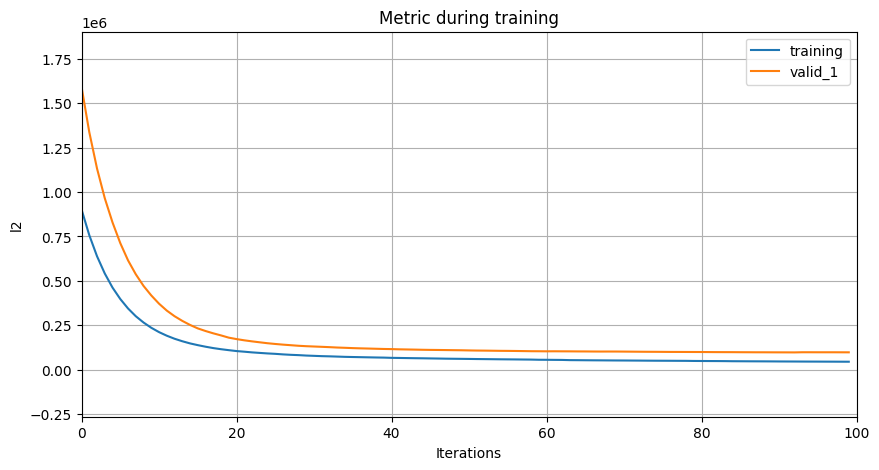

In [33]:
trainer.plot_metrics(['Optuna LightGBM'])

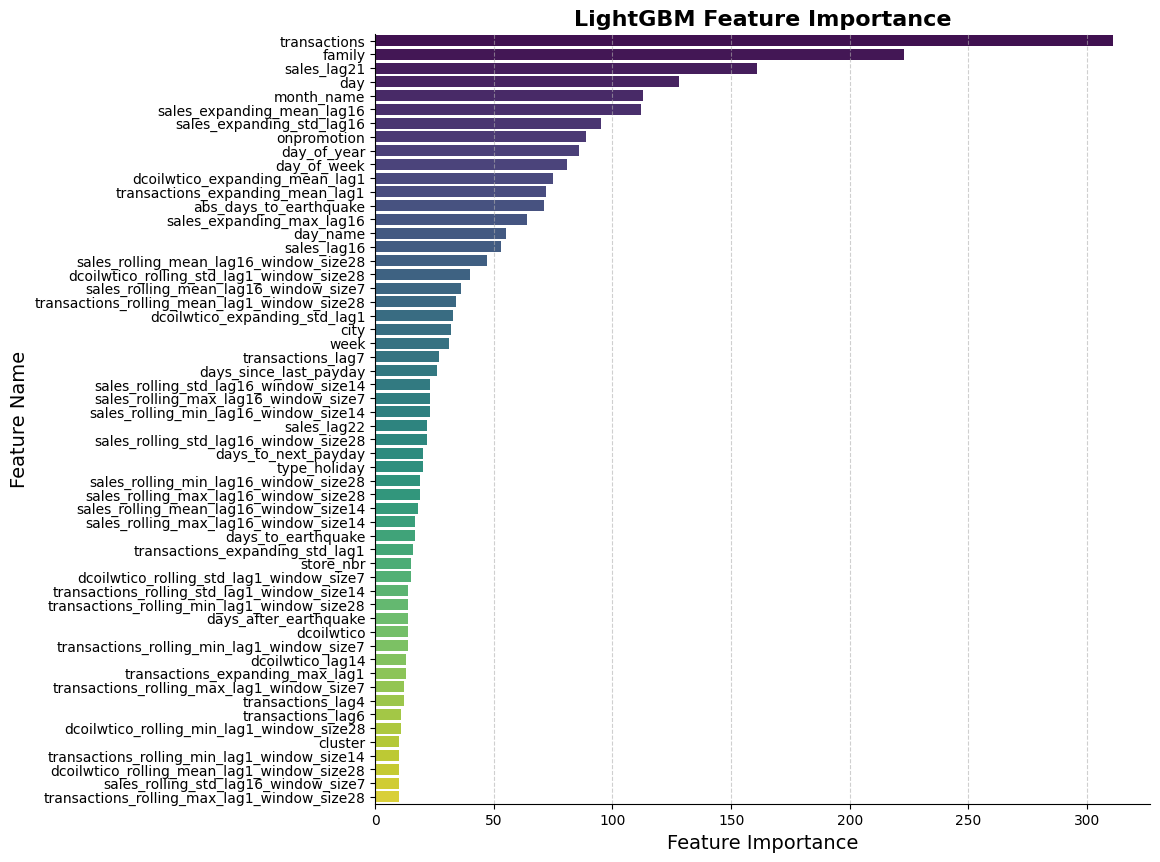

In [38]:
trainer.plot_feature_importance(['Optuna LightGBM'], top_percent=0.5, figsize=(10,10))

##### Ensemble

In [133]:
lgb_params = {
    "boosting_type": "gbdt",
    "objective": "tweedie",
    "tweedie_variance_power": 1.1,
    "n_estimators": 1500,
    "metric": "rmsle",
    "learning_rate": 0.015,
    "feature_fraction": 0.5,
    "bagging_fraction": 0.5,
    "bagging_frequency": 1,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    "max_depth": 11,
    # "min_data_in_leaf": 50,
    # "max_bin": 255,
    # "device": "gpu",
    "boost_from_average": False,
    "n_jobs": -1,
    "seed": 2004,
    "verbose": -1,
}

In [134]:
trainer_ensemble = Trainer(X,y)

In [139]:
# ensemble_results = trainer_ensemble.train_ensemble(
#     model_names=["Ensemble Family", "Ensemble Type", "Ensemble Cluster"],
#     models_list=["lgbm", "lgbm", "lgbm"],
#     params_list=[lgb_params, lgb_params, lgb_params],
#     ensemble_cols=["family", "type", "cluster"],
# )
ensemble_results = trainer_ensemble.train_ensemble(
    model_names=["Ensemble Family"],
    models_list=["lgbm"],
    # params_list=[{'verbose':-1, 'n_jobs':-1}],
    params_list=[lgb_params],
    ensemble_cols=["family"],
)


Training for Ensemble Column: [family]

Unique values in [family]: ['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', ..., 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD']
Length: 33
Categories (33, object): ['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', ..., 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD']
Model: [Ensemble Family] - Type: [lgbm] - Unique Value: [AUTOMOTIVE] - ID: [1]
RMSLE: 0.5002 | RMSE: 3.34 | MAE: 2.2844 | R2: 0.709
Model: [Ensemble Family] - Type: [lgbm] - Unique Value: [BABY CARE] - ID: [2]
RMSLE: 0.1467 | RMSE: 0.311 | MAE: 0.0947 | R2: 0.7915
Model: [Ensemble Family] - Type: [lgbm] - Unique Value: [BEAUTY] - ID: [3]
RMSLE: 0.4407 | RMSE: 2.0696 | MAE: 1.3706 | R2: 0.8137
Model: [Ensemble Family] - Type: [lgbm] - Unique Value: [BEVERAGES] - ID: [4]
RMSLE: 0.1555 | RMSE: 342.7774 | MAE: 205.8635 | R2: 0.9779
Model: [Ensemble Family] - Type: [lgbm] - Unique Value: [BOOKS] - ID: [5]
RMSLE: 0.0672 | 

In [140]:
ensemble_preds = trainer_ensemble.predict_ensemble(test_df[train_cols], ensemble_cols=['family'])

Predicting for Ensemble Column: [family]
Unique value: [AUTOMOTIVE]
Unique value: [BABY CARE]
Unique value: [BEAUTY]
Unique value: [BEVERAGES]
Unique value: [BOOKS]
Unique value: [BREAD/BAKERY]
Unique value: [CELEBRATION]
Unique value: [CLEANING]
Unique value: [DAIRY]
Unique value: [DELI]
Unique value: [EGGS]
Unique value: [FROZEN FOODS]
Unique value: [GROCERY I]
Unique value: [GROCERY II]
Unique value: [HARDWARE]
Unique value: [HOME AND KITCHEN I]
Unique value: [HOME AND KITCHEN II]
Unique value: [HOME APPLIANCES]
Unique value: [HOME CARE]
Unique value: [LADIESWEAR]
Unique value: [LAWN AND GARDEN]
Unique value: [LINGERIE]
Unique value: [LIQUOR,WINE,BEER]
Unique value: [MAGAZINES]
Unique value: [MEATS]
Unique value: [PERSONAL CARE]
Unique value: [PET SUPPLIES]
Unique value: [PLAYERS AND ELECTRONICS]
Unique value: [POULTRY]
Unique value: [PREPARED FOODS]
Unique value: [PRODUCE]
Unique value: [SCHOOL AND OFFICE SUPPLIES]
Unique value: [SEAFOOD]


In [141]:
ensemble_preds

,id,Ensemble Family,sales_ensemble
0,3000888,4.709007,4.709007
1,3000889,0.001590,0.001590
2,3000890,5.580938,5.580938
3,3000891,2334.796342,2334.796342
4,3000892,0.012993,0.012993
...,...,...,...
28507,3029395,364.636784,364.636784
28508,3029396,108.488416,108.488416
28509,3029397,1358.624731,1358.624731
28510,3029398,120.422302,120.422302


In [143]:
trainer_ensemble.export(ensemble_preds["sales_ensemble"], "ensemble_family_all_features.csv")

Exported to ensemble_family_all_features.csv
